# FFT via Split-Radix2

Wir wollen uns heute einmal mit dem Algorithmus beschäftigen, der überhaupt moderne Signalverarbeitung möglich macht -- die Implementierung der DFT durch die FFT. Er wurde zuerst 1876 von Carl Friedrich Gauß entwickelt und publiziert. Wurde dann jedoch vergessen und erst 160 Jahre später von Cooley und Tukey neu entdeckt. Der Einfachheit halber beschränken wir uns hierbei auf Anwendung auf Signale, deren Länge eine Potenz von $2$ ist.

Die DFT $X[k]$ einer Sequenz $x[n]$ der Länge $N$ wird berechnet via
$$
X[k] = \sum_{n=0}^{N-1} x[n] \exp\left(-\frac{2\pi \jmath n k}{N}\right).
$$

## Referenzimplementierung

Zunächst benötigen wir eine geeignete Referenzimplementierung, von der wir leicht ableiten können, dass sie korrekt ist. Diese benutzen wir als Test für unsere eigenen Versionen. Hierbei verlassen wir uns auf `numpy` und hoffen, dass deren Implementierung zuverlässig funktioniert. Unten rufen wir also `np.fft.fft` auf und schreiben gleichzeitig eine kleine Funktion, welche uns ein bisschen das Testen selbst automatisiert.

In [1]:
import numpy as np
from typing import Callable

def reference(inputSequence: np.ndarray) -> np.ndarray:
    outputSequence = np.fft.fft(inputSequence)
    
    return outputSequence

def test(implementation: Callable[[np.ndarray], np.ndarray]):
    testLength = 16
    testVector = np.random.randn(testLength) + np.random.randn(testLength)
    try:
        assert np.allclose(implementation(testVector), reference(testVector))
    except AssertionError:
        print("Wrong Implementation")

## Naive Implementierung

Als erstes sollten wir versuchen, die naive Version zu realisieren, welche gegeben $x[n]$ die Folge $X[k]$ basierend auf einfacher Summation für einzelne $k$ berechnet. Die Berechnung folgt also direkt aus der Definition der DFT.

**Aufgabe:** 
 
 - Schreiben Sie eine Funktion basierend auf der Definition der DFT.
 - Welche Laufzeitkomplexität hat dieser Algorithmus?
 - Nutzen Sie den bereitgestellten Test für die Überprüfung auf Korrektheit.
 - Testen Sie den Test, indem sie eine Funktion schreiben, für welche der Test scheitert.

In [2]:
def naive(inputSequence: np.ndarray) -> np.ndarray:
    outputSequence = np.zeros(inputSequence.shape, dtype=complex)
    length = inputSequence.size
    for kk in range(length):
        for nn in range(length):
            outputSequence[kk] += inputSequence[nn] * np.exp(-1j * 2 * np.pi * nn * kk / length)
    
    return outputSequence

test(naive)

def wrong(inputSequence: np.ndarray) -> np.ndarray:
    outputSequence = np.zeros(inputSequence.shape, dtype=complex)
    length = inputSequence.size
    for kk in range(length):
        for nn in range(length):
            outputSequence[kk] += inputSequence[nn] * np.exp(-1j * 2 * np.pi * nn * (kk-1) / length)
    
    return outputSequence

test(wrong)


Wrong Implementation


## Matrix-Vektor-Multiplikation

Eine erste und hoffentlich etwas schnellere Variante ist die Implementierung als Matrix-Vektor-Produkt. Hierzu nutzen wir einen kleinen Python-Trick, der es uns erlaubt Python-Objekte `Callable` zu machen. Dies hat den Vorteil, dass wir die DFT-Matrix nur einmal berechnen müssen und für die eigentliche Berechnung auf die fertige Matrix zugreifen können.

**Aufgabe:** 
 
 - Implementieren Sie eine Klasse, die bei Initialisierung die DFT-Matrix vorberechnet.
 - Welche Laufzeitkomplexität hat dieser Algorithmus? Speicherbedarf?
 - Testen Sie Ihre Implementierung für $n=16$.

In [3]:
class matrix:
    def __call__(self, inputSequence: np.ndarray) -> np.ndarray:
        outputSequence = self._matrix.dot(inputSequence)
        return outputSequence
    
    def __init__(self, length: int):
        self._matrix = np.zeros((length, length), dtype=complex)
        for kk in range(length):
            for nn in range(length):
                self._matrix[kk, nn] = np.exp(-1j * 2 * np.pi * nn * kk / length)

dft16 = matrix(16)
test(dft16)

## Einzelner Split-Radix

Die wichtigste Idee bei Split-Radix ist die Umsortierung der Summation in der naiven Formel der DFT. Wir teilen die Summe in die Summanden für $n = 2m$ und $n = 2m+1$ aus. Also gerade und ungerade Indices der Sequenz $x[n]$. Nach Umsortieren erhalten wir
$$
\begin{matrix} X[k] & =
& \sum \limits_{m=0}^{N/2-1} x[2m] \exp\left(-\frac{2\pi \jmath}{N} (2m)k\right) 
+ \sum \limits_{m=0}^{N/2-1} x[2m+1] \exp\left(-\frac{2\pi \jmath}{N} (2m+1)k\right)
  \end{matrix}.
$$
Nach Ausklammern im zweiten Summanden ergibt sich
$$
\begin{matrix} X[k] & =
& \sum \limits_{m=0}^{N/2-1} x[2m] \exp\left(-\frac{2\pi \jmath mk }{N/2} \right) 
+  \exp\left(-\frac{2\pi \jmath k}{N}\right) \sum \limits_{m=0}^{N/2-1} x[2m+1] \exp\left(-\frac{2\pi \jmath mk}{N/2} \right)
  \end{matrix}.
$$
Definieren wir $e[m] = x[2m]$ und $o[m] = x[2m+1]$, dann erhalten wir zunächst für $k = 0,\dots,N/2-1$
$$
X[k] = E[k] + \exp\left(-\frac{2\pi \jmath k}{N}\right) O[k].
$$
Dies ist der Tatsache geschuldet, dass $e[m]$ und $o[m]$ Sequenzen der Länge $N/2$ sind. Wir haben aber durch die Periodizität der komplexen $e$-Funktion auch gegeben, dass:
$$
X[k + N/2] = E[k] - \exp\left(-\frac{2\pi \jmath k}{N}\right) O[k].
$$
Dies erlaubt es uns nun die DFT eines Vektors der Länge $N$ durch zwei DFTs der Länge $N/2$ darzustellen.
**Aufgabe:** 
 
 - Implementieren Sie eine Funktion, welche einen Schritt des Split-Radix-Algorithmus implementiert indem es ihre Version von `naive` benutzt, um die DFTs für Größen $n/2$ zu berechnen.
 - Welche Laufzeitkomplexität hat dieser Algorithmus?
 - Testen Sie Ihre Implementierung für $n=16$.

In [4]:
def single_split_radix(inputSequence: np.ndarray) -> np.ndarray:
    length = inputSequence.size
    
    evenInputs = inputSequence[::2]
    oddInputs = inputSequence[1::2]
    
    evenDFT = naive(evenInputs)
    oddDFT = naive(oddInputs)
    
    outputIndices = np.arange(length // 2)
    
    outputSequence1 = evenDFT + np.exp(-1j * 2 * np.pi * outputIndices / length) * oddDFT
    outputSequence2 = evenDFT - np.exp(-1j * 2 * np.pi * outputIndices / length) * oddDFT
    
    return np.concatenate([outputSequence1, outputSequence2])

test(single_split_radix)

## Rekursiver Split-Radix

Da wir davon ausgehen, dass unsere Sequenzen immer Länge $n = 2^L$ erfüllen, können wir `single_split_radix` auch so modifizieren, dass es für Längen $n > 2$ sich selbst aufruft, um die DFT der geraden und ungeraden Sequenzen wieder mit derselben Funktion berechnet werden. Um Rekursion zu verstehen, muss man zunächst Rekursion verstehen...

**Aufgabe:**
 
 - Modifizieren Sie `single_split_radix` so, dass es sich selbst rekursiv aufrufen kann.
 - Implementieren Sie die DFT rekursiv.
 - Welche Rechenkomplexität ergibt sich nun?

In [5]:
def split_radix(inputSequence: np.ndarray) -> np.ndarray:
    length = inputSequence.size
    
    if length == 1:
        return inputSequence
    
    evenInputs = inputSequence[::2]
    oddInputs = inputSequence[1::2]
    
    evenDFT = split_radix(evenInputs)
    oddDFT = split_radix(oddInputs)
    
    outputIndices = np.arange(length // 2)
    twiddleFactors = np.exp(-1j * 2 * np.pi * outputIndices / length)
    
    outputSequence1 = evenDFT + twiddleFactors * oddDFT
    outputSequence2 = evenDFT - twiddleFactors * oddDFT
    
    return np.concatenate([outputSequence1, outputSequence2])

test(split_radix)

## Benchmarking

Wir rufen nun einfach all unsere Implementierungen für verschiedene Problemgrößen auf und vergleichen die Laufzeiten.

In [6]:
import timeit

sizes = 2 ** np.arange(8)

def bench(fun: Callable) -> float:
    fun()
    return np.mean(timeit.repeat(fun, repeat=5, number=10)) / 10

ref_times = []
nav_times = []
dft_times = []
sng_times = []
srd_times = []

for ss in sizes:
    print(f"Benchmarking size n={ss}")
    x = np.random.randn(ss) + 1j * np.random.randn(ss)
    
    def ref():
        reference(x)
        
    def nav():
        naive(x)
        
    dft_ss = matrix(ss)
    def dft():
        dft_ss(x)
        
    def sng():
        single_split_radix(x)
        
    def srd():
        split_radix(x)
    
    ref_times.append(bench(ref))
    nav_times.append(bench(nav))
    dft_times.append(bench(dft))
    sng_times.append(bench(sng))
    srd_times.append(bench(srd))
    

Benchmarking size n=1
Benchmarking size n=2
Benchmarking size n=4
Benchmarking size n=8
Benchmarking size n=16
Benchmarking size n=32
Benchmarking size n=64
Benchmarking size n=128


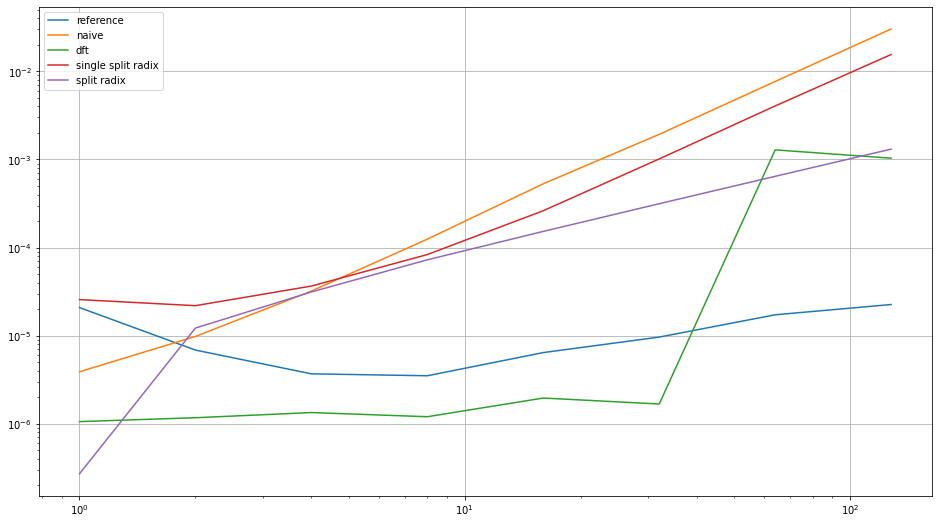

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]
plt.loglog(sizes, ref_times, label="reference")
plt.loglog(sizes, nav_times, label="naive")
plt.loglog(sizes, dft_times, label="dft")
plt.loglog(sizes, sng_times, label="single split radix")
plt.loglog(sizes, srd_times, label="split radix")
plt.grid(True)
plt.legend()
plt.show()